In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import transforms3d as tf3d
import matplotlib
import scipy.signal
import time
from numba import jit
from scipy.integrate import odeint
from scipy.interpolate import interp1d

In [2]:
mass=369 #batterie
mass+=1640-114 #corps-carton
mass/=1e3
Area=np.pi*(11.0e-02)**2
r0=11e-02
rho0=1.204
kv_motor=800.0
pwmmin=1075.0
pwmmax=1950.0
U_batt=16.8
AN=6*Area
b10=14.44

In [3]:
# %%   ####### IMPORT DATA 
print("LOADING DATA...")


log_path="./logs/copter/vol12/log_real_processed.csv"

raw_data=pd.read_csv(log_path)

print("PROCESSING DATA...")


prep_data=raw_data.drop(columns=[i for i in raw_data.keys() if (("forces" in i ) or ('pos' in i) or ("joy" in i)) ])
prep_data=prep_data.drop(columns=[i for i in raw_data.keys() if (("level" in i ) or ('Unnamed' in i) or ("index" in i)) ])
# print(prep_data)

if "vol12" in log_path:
    tmin,tmax=(-1,1e10) 
elif "vol1/" in log_path:
    tmin,tmax=(41,265) 
elif "vol2" in log_path:
    tmin,tmax=(10,140) 
    
prep_data=prep_data[prep_data['t']>tmin]
prep_data=prep_data[prep_data['t']<tmax]
prep_data=prep_data.reset_index()
for i in range(3):
    prep_data['speed_pred[%i]'%(i)]=np.r_[prep_data['speed[%i]'%(i)].values[1:len(prep_data)],0]
    
    

prep_data['dt']=np.r_[prep_data['t'].values[1:]-prep_data['t'].values[:-1],0]
prep_data['t']-=prep_data['t'][0]
prep_data=prep_data.drop(index=[0,len(prep_data)-1])




for i in range(6):
    prep_data['omega_c[%i]'%(i+1)]=(prep_data['PWM_motor[%i]'%(i+1)]-pwmmin)/(pwmmax-pwmmin)*U_batt*kv_motor*2*np.pi/60

R_array=np.array([tf3d.quaternions.quat2mat([i,j,k,l]) for i,j,k,l in zip(prep_data['q[0]'],
                                                                          prep_data['q[1]'],
                                                                          prep_data['q[2]'],
                                                                          prep_data['q[3]'])])

vwx_body_dir=np.array([i.T@np.array([[1.0],[0],[0]]) for i in R_array] )
vwy_body_dir=np.array([i.T@np.array([[0.0],[1.0],[0]]) for i in R_array] )


prep_data['vwx_body_dir']=[i for i in vwx_body_dir.reshape((-1,3))]
prep_data['vwy_body_dir']=[i for i in vwy_body_dir.reshape((-1,3))]
prep_data['vwx_body_dir']=[i for i in vwx_body_dir.reshape((-1,3))]
prep_data['R']=[i for i in R_array]

LOADING DATA...
PROCESSING DATA...


In [4]:

# %%   ####### Identify Thrust 

def compute_single_motor_thrust_MT(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T


def compute_single_motor_thrust_BET(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=rho0*Area*r0*omega*(c1*r0*omega-c2*(eta-vak))
    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T

def compute_acc_k(c1,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma
    
    return acc_k



def cost_vanilla(X):
    c1=X
    Y=compute_acc_k(c1,vanilla=True)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: VANILLA ,cost :%f"%(c1,c))
    return c

X0_vanilla=np.array([6e-6])

sol_vanilla=minimize(cost_vanilla,X0_vanilla,method="SLSQP")
c1vanilla=sol_vanilla['x']
print("\n \n")

def cost(X):
    c1,c2=X
    Y=compute_acc_k(c1,c2=c2)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: %f,cost :%f"%(c1,c2,c))
    return c


X0=np.zeros(2)
sol_custom=minimize(cost,X0,method="SLSQP")

c1sol,c2sol=sol_custom['x']



c1 :0.000006 ,c2: VANILLA ,cost :97.823856
c1 :0.000006 ,c2: VANILLA ,cost :97.823586
c1 :18106.892889 ,c2: VANILLA ,cost :277749637567622.125000
c1 :1810.689294 ,c2: VANILLA ,cost :2777466868391.035645
c1 :181.068935 ,c2: VANILLA ,cost :27771718042.551456
c1 :18.106899 ,c2: VANILLA ,cost :277422203.450702
c1 :1.810695 ,c2: VANILLA ,cost :2744811.498081
c1 :0.181075 ,c2: VANILLA ,cost :24594.222394
c1 :0.018113 ,c2: VANILLA ,cost :47.714021
c1 :0.018113 ,c2: VANILLA ,cost :47.714208
c1 :0.010693 ,c2: VANILLA ,cost :1.071324
c1 :0.010693 ,c2: VANILLA ,cost :1.071324

 

c1 :0.000000 ,c2: 0.000000,cost :97.932528
c1 :0.000000 ,c2: 0.000000,cost :97.932258
c1 :0.000000 ,c2: 0.000000,cost :97.932529
c1 :18117.058962 ,c2: -117.047690,cost :933620129182321.500000
c1 :1811.705896 ,c2: -11.704769,cost :4099964053475.644043
c1 :181.170590 ,c2: -1.170477,cost :31441799344.512997
c1 :18.117059 ,c2: -0.117048,cost :288762801.033847
c1 :1.811706 ,c2: -0.011705,cost :2782186.596157
c1 :0.181171 ,c2:

/home/l3x/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


c1 :-0.033177 ,c2: -0.581459,cost :6102.567640
c1 :0.026130 ,c2: 0.202171,cost :0.714439
c1 :0.026130 ,c2: 0.202171,cost :0.714440
c1 :0.026130 ,c2: 0.202171,cost :0.714439
c1 :-0.015310 ,c2: -0.338580,cost :566.539292
c1 :0.021986 ,c2: 0.148096,cost :0.630712
c1 :0.021986 ,c2: 0.148096,cost :0.630712
c1 :0.021986 ,c2: 0.148096,cost :0.630712
c1 :0.016181 ,c2: 0.072586,cost :0.644901
c1 :0.019505 ,c2: 0.115820,cost :0.608828
c1 :0.019505 ,c2: 0.115820,cost :0.608828
c1 :0.019505 ,c2: 0.115820,cost :0.608828
c1 :0.019075 ,c2: 0.110592,cost :0.608609
c1 :0.019075 ,c2: 0.110592,cost :0.608609
c1 :0.019075 ,c2: 0.110592,cost :0.608609
c1 :0.019033 ,c2: 0.109598,cost :0.608555
c1 :0.019052 ,c2: 0.110044,cost :0.608449
c1 :0.019052 ,c2: 0.110044,cost :0.608449
c1 :0.019052 ,c2: 0.110044,cost :0.608449
c1 :0.019232 ,c2: 0.112378,cost :0.608419
c1 :0.019232 ,c2: 0.112378,cost :0.608419
c1 :0.019232 ,c2: 0.112378,cost :0.608419
c1 :0.019165 ,c2: 0.111517,cost :0.608405
c1 :0.019165 ,c2: 0.11151


Performances: 
RMS error on acc pred is : 
RMS error : 1.0350 for vanilla, 0.7800 for custom model


Coherence with ct2=ct1*b1-2/b1 formula ?

with the formula : 
ct2=0.138241
with the identification : 
ct2=0.111517


Coherence with TMT=TBET ?

output difference rms : 2.0489839059854735e-15 m/s


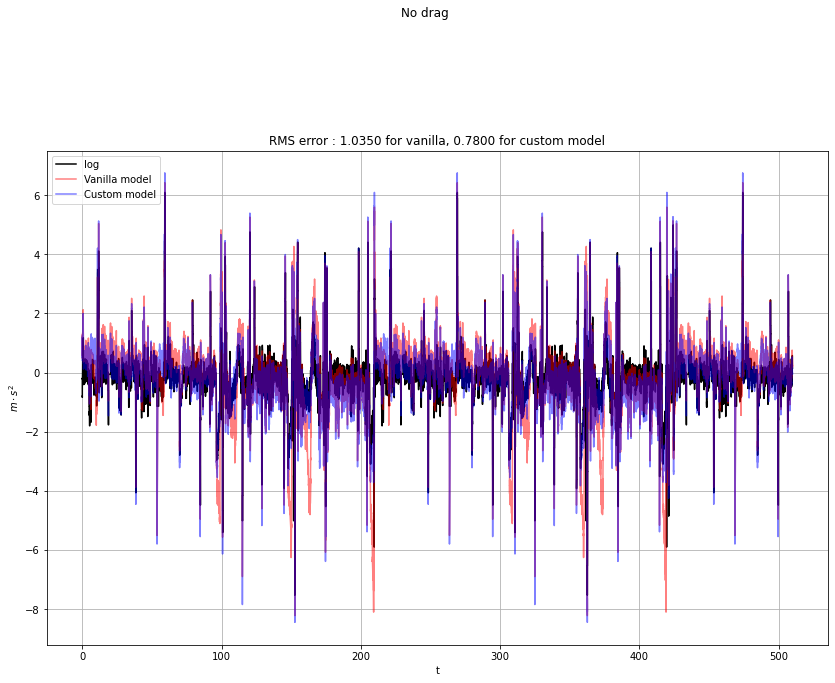

In [5]:
# %%% Comparison

f=plt.figure(figsize=(14,20))
f.suptitle(r"No drag")
ax=f.add_subplot(2,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label=r"log")
ax.plot(prep_data["t"],compute_acc_k(c1vanilla,vanilla=True),color="red",label=r"Vanilla model",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k(c1sol,c2=c2sol,model="MT"),color="blue",label=r"Custom model",alpha=0.5)
# ax.plot(prep_data["t"],compute_acc_k(c1sol,c2=c2sol,model="BET"),color="green",label=r"optimized, MT",alpha=0.5)
ax.set_ylabel(r'$m \cdot {s^{2}}$')
ax.set_xlabel(r't')
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s=r"RMS error : %.4f for vanilla, %.4f for custom model"%(round(np.sqrt(sol_vanilla['fun']),3),round(np.sqrt(sol_custom['fun']),4))
print(s)
ax.set_title(s)

print('\n\nCoherence with ct2=ct1*b1-2/b1 formula ?\n')
print('with the formula : ')
print("ct2=%f"%(c1sol*b10-2/b10))
print("with the identification : ")
print("ct2=%f"%(c2sol))


print('\n\nCoherence with TMT=TBET ?\n')
yrms=np.sqrt(np.mean((compute_acc_k(c1sol,c2=c2sol,model="MT")-compute_acc_k(c1sol,c2=c2sol,model="BET"))**2))
print("output difference rms : %s m/s"%(yrms))

In [6]:
compute_acc_k(c1sol,c2=c2sol,model="MT")

1         0.415034
2         0.424218
3         0.430951
4         0.464609
5         0.501423
            ...   
120494   -0.049319
120495   -0.036540
120496   -0.023206
120497   -0.012818
120498   -0.012660
Length: 120498, dtype: float64

In [7]:
c2sol/2/c1sol+0.5*np.sqrt(c2sol**2/c1sol**2+8/c1sol)

13.531036222844767

In [8]:
compute_acc_k(c1sol,c2=c2sol,model="MT")-compute_acc_k(c1sol,c2=c2sol,model="BET")

1         1.776357e-15
2         1.776357e-15
3         1.776357e-15
4         0.000000e+00
5        -1.776357e-15
              ...     
120494    0.000000e+00
120495    3.552714e-15
120496    3.552714e-15
120497    0.000000e+00
120498    0.000000e+00
Length: 120498, dtype: float64

In [9]:

# %%   ####### Identify Thrust(with dk)


def compute_single_motor_thrust_MT_wdrag(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T


def compute_single_motor_thrust_BET_wdrag(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=rho0*Area*r0*omega*(c1*r0*omega-c2*(eta-vak))
    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T

def compute_acc_k_wdrag(c1,dk,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma-rho0*AN*dk*np.abs(vak)*vak/mass
    
    return acc_k

from scipy.optimize import minimize

import matplotlib.pyplot as plt


def cost_vanilla_wdrag(X):
    c1,dk=X
    Y=compute_acc_k_wdrag(c1,dk,vanilla=True)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: VANILLA , dk: %f ,cost :%f"%(c1,dk,c))
    return c

X0_vanilla=np.array([6e-6,0])

sol_vanilla_drag=minimize(cost_vanilla_wdrag,X0_vanilla,method="SLSQP")
c1vanilla,dkvanilla=sol_vanilla_drag['x']


def cost_wdrag(X):
    c1,c2,dk=X
    Y=compute_acc_k_wdrag(c1,dk,c2=c2)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: %f, dk: %f , cost :%f"%(c1,c2,dk,c))
    return c


X0=np.zeros(3)
sol_custom_drag=minimize(cost_wdrag,X0,method="SLSQP")

c1sol,c2sol,dksol=sol_custom_drag['x']



c1 :0.000006 ,c2: VANILLA , dk: 0.000000 ,cost :97.823856
c1 :0.000006 ,c2: VANILLA , dk: 0.000000 ,cost :97.823586
c1 :0.000006 ,c2: VANILLA , dk: 0.000000 ,cost :97.823856
c1 :18106.892889 ,c2: VANILLA , dk: -3.195520 ,cost :277749660064332.000000
c1 :1810.689294 ,c2: VANILLA , dk: -0.319552 ,cost :2777467093357.193848
c1 :181.068935 ,c2: VANILLA , dk: -0.031955 ,cost :27771720292.121162
c1 :18.106899 ,c2: VANILLA , dk: -0.003196 ,cost :277422225.937213
c1 :1.810695 ,c2: VANILLA , dk: -0.000320 ,cost :2744811.722027
c1 :0.181075 ,c2: VANILLA , dk: -0.000032 ,cost :24594.224541
c1 :0.018113 ,c2: VANILLA , dk: -0.000003 ,cost :47.714033
c1 :0.018113 ,c2: VANILLA , dk: -0.000003 ,cost :47.714220
c1 :0.018113 ,c2: VANILLA , dk: -0.000003 ,cost :47.714033
c1 :0.010913 ,c2: VANILLA , dk: 0.959640 ,cost :0.597532
c1 :0.010913 ,c2: VANILLA , dk: 0.959640 ,cost :0.597532
c1 :0.010913 ,c2: VANILLA , dk: 0.959640 ,cost :0.597532
c1 :0.010919 ,c2: VANILLA , dk: 0.987407 ,cost :0.597136
c1 :0.010

/home/l3x/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


c1 :0.018745 ,c2: 0.106290, dk: 0.049995 , cost :0.605724
c1 :0.018745 ,c2: 0.106290, dk: 0.049995 , cost :0.605724
c1 :0.018745 ,c2: 0.106291, dk: 0.049995 , cost :0.605724
c1 :0.018745 ,c2: 0.106290, dk: 0.049995 , cost :0.605724
c1 :0.009692 ,c2: -0.017540, dk: 0.780427 , cost :0.721247
c1 :0.017303 ,c2: 0.086568, dk: 0.166330 , cost :0.598295
c1 :0.017303 ,c2: 0.086568, dk: 0.166330 , cost :0.598294
c1 :0.017303 ,c2: 0.086568, dk: 0.166330 , cost :0.598295
c1 :0.017303 ,c2: 0.086568, dk: 0.166330 , cost :0.598295
c1 :0.013341 ,c2: 0.032165, dk: 0.570328 , cost :0.593389
c1 :0.013341 ,c2: 0.032165, dk: 0.570328 , cost :0.593390
c1 :0.013341 ,c2: 0.032165, dk: 0.570328 , cost :0.593389
c1 :0.013341 ,c2: 0.032165, dk: 0.570328 , cost :0.593389
c1 :0.015101 ,c2: 0.056048, dk: 0.476592 , cost :0.588684
c1 :0.015101 ,c2: 0.056048, dk: 0.476592 , cost :0.588684
c1 :0.015101 ,c2: 0.056048, dk: 0.476592 , cost :0.588684
c1 :0.015101 ,c2: 0.056048, dk: 0.476593 , cost :0.588684
c1 :0.014399 

In [10]:

# %%% Comparison

f.suptitle("Thrust no drag / With drag")
ax=f.add_subplot(2,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1vanilla,dkvanilla,vanilla=True),color="red",label="pred",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="MT"),color="blue",label="optimized, MT",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="BET"),color="green",label="optimized, MT",alpha=0.5)
ax.legend()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s="%f for vanilla, %f for custom model"%(sol_vanilla_drag['fun'],sol_custom_drag['fun'])
ax.set_title(s)
print(s)


print('\n\nCoherence with ct2=ct1*b1-2/b1 formula ?\n')
print('with the formula : ')
print("ct2=%f"%(c1sol*b10-2/b10))
print("with the identification : ")
print("ct2=%f"%(c2sol))


print('\n\nCoherence with TMT=TBET ?\n')
yrms=np.sqrt(np.mean((compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="MT")-compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="BET"))**2))
print("output difference rms : %s m/s"%(yrms))

# %%% Comparison
f.suptitle("Vanilla / Augmented with drag")
ax=f.add_subplot(2,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1vanilla,dkvanilla,vanilla=True),color="darkred",label="pred",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="MT"),color="darkblue",label="optimized, MT",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="BET"),color="darkgreen",label="optimized, MT",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
print("%f for vanilla, %f for custom model"%(sol_vanilla_drag['fun'],sol_custom_drag['fun']))


print('\n\nCoherence with ct2=ct1*b1-2/b1 formula ?\n')
print('with the formula : ')
print("ct2=%f"%(c1sol*b10-2/b10))
print("with the identification : ")
print("ct2=%f"%(c2sol))


print('\n\nCoherence with TMT=TBET ?\n')
yrms=np.sqrt(np.mean((compute_acc_k_wdrag(c1sol,dkvanilla,c2=c2sol,model="MT")-compute_acc_k_wdrag(c1sol,dkvanilla,c2=c2sol,model="BET"))**2))
print("output difference rms : %s m/s"%(yrms))


Performances: 
RMS error on acc pred is : 
0.597136 for vanilla, 0.586809 for custom model


Coherence with ct2=ct1*b1-2/b1 formula ?

with the formula : 
ct2=0.060567
with the identification : 
ct2=0.038651


Coherence with TMT=TBET ?

output difference rms : 1.7079708408764411e-15 m/s

Performances: 
RMS error on acc pred is : 
0.597136 for vanilla, 0.586809 for custom model


Coherence with ct2=ct1*b1-2/b1 formula ?

with the formula : 
ct2=0.060567
with the identification : 
ct2=0.038651


Coherence with TMT=TBET ?

output difference rms : 1.7080110870249378e-15 m/s


In [11]:

# %%%   ####### Identify wirhout drag

def compute_ai_nod(di,df=prep_data):
    
    vai=df["speed_body[0]"]
    Fa=-rho0*AN*di*np.abs(vai)*vai
    gamma=df["gamma[0]"]

    return gamma

def cost_ai_nodrag(X):
    di=X
    
    Y=compute_ai_nod(di)
    c=np.mean((Y-prep_data['acc_body_grad[0]'])**2,axis=0)
    print("di :%f , cost :%f"%(di,c))

    return c
    
X0_di_nodrag=np.array([0])

sol_ai_nod=minimize(cost_ai_nodrag,X0_di_nodrag,method="SLSQP")
di_nod_=sol_ai_nod['x']
print("\n \n")


di :0.000000 , cost :0.084489
di :0.000000 , cost :0.084489

 



In [12]:
np.sqrt(sol_ai_nod['fun'])

0.2906702248676472

(<matplotlib.legend.Legend at 0x7f245c5b1250>,
 None,
 Text(0.5, 0, 't'),
 Text(0, 0.5, '$m \\cdot {s^{2}}$'))

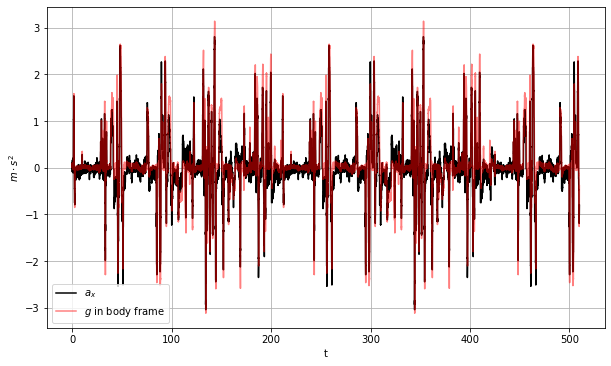

In [13]:
f=plt.figure(figsize=(10,13))
ax=f.add_subplot(2,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label=r"$a_x$")
ax.plot(prep_data["t"],compute_ai_nod(0),color="red",label=r"$g$ in body frame",alpha=0.5)
ax.legend(),ax.grid(),ax.set_xlabel('t'),ax.set_ylabel(r'$m \cdot {s^{2}}$')


In [14]:

# %%%   ####### Identify pure drag

def compute_ai_od(di,df=prep_data):
    
    vak=df["speed_body[0]"]
    Fa=-rho0*AN*di*np.abs(vak)*vak
    gamma=df["gamma[0]"]

    return Fa/mass+gamma

def cost_ai_onlydrag(X):
    di=X
    
    Y=compute_ai_od(di)
    c=np.mean((Y-prep_data['acc_body_grad[0]'])**2,axis=0)
    print("di :%f , cost :%f"%(di,c))

    return c
    
X0_di_onlydrag=np.array([0])

sol_ai_od=minimize(cost_ai_onlydrag,X0_di_onlydrag,method="SLSQP")
di_only_=sol_ai_od['x']
print("\n \n")


di :0.000000 , cost :0.084489
di :0.000000 , cost :0.084489
di :0.089455 , cost :0.076846
di :0.089455 , cost :0.076846
di :0.496613 , cost :0.051125
di :0.496613 , cost :0.051125
di :0.997310 , cost :0.039882
di :0.997310 , cost :0.039882

 



In [15]:

# %%%   ####### Identify H-force nodrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_ai_H_only(ch1,ch2,df=prep_data):

    vai=df["speed_body[0]"]
    vak=df["speed_body[2]"]

    gamma=df["gamma[0]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=-vai*H
    
    return H_vect/mass+gamma

def cost_ai_h_only(X):
    ch1,ch2=X

    Y=compute_ai_H_only(ch1,ch2)
    c=np.mean((Y-prep_data['acc_body_grad[0]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , cost :%f"%(ch1,ch2,c))

    return c

X0_ai_onlyh=np.array([0,0])

sol_ai_oh=minimize(cost_ai_h_only,X0_ai_onlyh,method="SLSQP")
ch1_ai_only_,ch2_ai_only_=sol_ai_oh['x']
print("\n \n")

ch1 :0.000000 , ch2 :0.000000 , cost :0.084489
ch1 :0.000000 , ch2 :0.000000 , cost :0.084489
ch1 :0.000000 , ch2 :0.000000 , cost :0.084489
ch1 :4.301938 , ch2 :-0.342024 , cost :1778.479855
ch1 :0.430194 , ch2 :-0.034202 , cost :16.192314
ch1 :0.043019 , ch2 :-0.003420 , cost :0.077955
ch1 :0.022292 , ch2 :-0.001772 , cost :0.036237
ch1 :0.022292 , ch2 :-0.001772 , cost :0.036237
ch1 :0.022292 , ch2 :-0.001772 , cost :0.036237
ch1 :0.022043 , ch2 :-0.004931 , cost :0.036227
ch1 :0.022043 , ch2 :-0.004931 , cost :0.036227
ch1 :0.022043 , ch2 :-0.004931 , cost :0.036227
ch1 :0.020827 , ch2 :-0.020372 , cost :0.036182
ch1 :0.020827 , ch2 :-0.020372 , cost :0.036182
ch1 :0.020827 , ch2 :-0.020372 , cost :0.036182
ch1 :0.015428 , ch2 :-0.088915 , cost :0.036046
ch1 :0.015428 , ch2 :-0.088915 , cost :0.036046
ch1 :0.015428 , ch2 :-0.088915 , cost :0.036046
ch1 :0.011199 , ch2 :-0.142606 , cost :0.036013
ch1 :0.011199 , ch2 :-0.142606 , cost :0.036013
ch1 :0.011199 , ch2 :-0.142606 , cost :

In [16]:

# %%%   ####### Identify H-force wdrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_ai_H_wdrag(ch1,ch2,di,df=prep_data):
    
    vai=df["speed_body[0]"]
    vak=df["speed_body[2]"]

    gamma=df["gamma[0]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=-vai*H
    Fa=-rho0*AN*di*np.abs(vai)*vai

    return H_vect/mass+gamma+Fa/mass

def cost_ai_h_wdrag(X):
    ch1,ch2,di=X

    Y=compute_ai_H_wdrag(ch1,ch2,di)
    c=np.mean((Y-prep_data['acc_body_grad[0]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , di :%f , cost :%f"%(ch1,ch2,di,c))

    return c

X0_ai_hwd=np.array([0,0,0])

sol_ai_hwd=minimize(cost_ai_h_wdrag,X0_ai_hwd,method="SLSQP")
ch1_ai_wd_,ch2_ai_wd_,di_wd_=sol_ai_hwd['x']

ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.084489
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.084489
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.084489
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.084489
ch1 :4.301938 , ch2 :-0.342024 , di :0.089455 , cost :1779.938937
ch1 :0.430194 , ch2 :-0.034202 , di :0.008946 , cost :16.206185
ch1 :0.043019 , ch2 :-0.003420 , di :0.000895 , cost :0.078021
ch1 :0.022283 , ch2 :-0.001772 , di :0.000463 , cost :0.036235
ch1 :0.022283 , ch2 :-0.001772 , di :0.000463 , cost :0.036235
ch1 :0.022283 , ch2 :-0.001772 , di :0.000463 , cost :0.036235
ch1 :0.022283 , ch2 :-0.001772 , di :0.000463 , cost :0.036235
ch1 :0.021946 , ch2 :-0.004923 , di :0.004948 , cost :0.036205
ch1 :0.021946 , ch2 :-0.004923 , di :0.004948 , cost :0.036205
ch1 :0.021946 , ch2 :-0.004923 , di :0.004948 , cost :0.036205
ch1 :0.021946 , ch2 :-0.004923 , di :0.004948 , cost :0.036205
ch1 :0.020299 , ch2 :-0.020304 , di :0.027022 , cost :0


Performances: 
RMS error on acc pred is : 
0.039882 for vanilla, 0.036013 for custom model, 0.035378 for full model


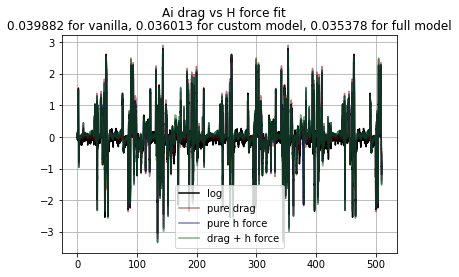

In [17]:

# %%%   ####### Comparison

f=plt.figure()
f.suptitle("Ai drag vs H force fit")
ax=f.add_subplot(1,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],compute_ai_od(di_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],compute_ai_H_only(ch1_ai_only_,ch2_ai_only_),color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],compute_ai_H_wdrag(ch1_ai_only_,ch2_ai_only_,di_wd_),color="darkgreen",label="drag + h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s="%f for vanilla, %f for custom model, %f for full model"%(sol_ai_od['fun'],sol_ai_oh['fun'],sol_ai_hwd['fun'])
ax.set_title(s)
print(s)



In [18]:

# %%%   ####### Identify wirhout drag

def compute_aj_nod(dj,df=prep_data):
    
    vaj=df["speed_body[1]"]
    Fa=-rho0*AN*dj*np.abs(vaj)*vaj
    gamma=df["gamma[1]"]

    return gamma

def cost_aj_nodrag(X):
    dj=X
    
    Y=compute_aj_nod(dj)
    c=np.mean((Y-prep_data['acc_body_grad[1]'])**2,axis=0)
    print("di :%f , cost :%f"%(dj,c))

    return c
    
X0_dj_nodrag=np.array([0])

sol_aj_nod=minimize(cost_aj_nodrag,X0_dj_nodrag,method="SLSQP")
dj_nod_=sol_aj_nod['x']
print("\n \n")

di :0.000000 , cost :0.692015
di :0.000000 , cost :0.692015

 



In [19]:
# %% aj
# %%%   ####### Identify pure drag

def compute_aj_od(dj,df=prep_data):
    
    vak=df["speed_body[1]"]
    Fa=-rho0*AN*dj*np.abs(vak)*vak
    gamma=df["gamma[1]"]

    return Fa/mass+gamma

def cost_aj_onlydrag(X):
    dj=X
    
    Y=compute_aj_od(dj)
    c=np.mean((Y-prep_data['acc_body_grad[1]'])**2,axis=0)
    print("dj :%f , cost :%f"%(dj,c))

    return c
    
X0_dj_onlydrag=np.array([1])

sol_aj_od=minimize(cost_aj_onlydrag,X0_dj_onlydrag,method="SLSQP")
dj_only_=sol_aj_od['x']
print("\n \n")

dj :1.000000 , cost :9.147597
dj :1.000000 , cost :9.147597
dj :-21.206903 , cost :6297.417806
dj :-1.220690 , cost :27.647109
dj :0.192554 , cost :0.182157
dj :0.192554 , cost :0.182157

 



In [20]:


# %%%   ####### Identify H-force nodrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_aj_H_only(ch1,ch2,df=prep_data):
    
    vak=df["speed_body[2]"]
    vaj=df["speed_body[1]"]

    gamma=df["gamma[1]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=-vaj*H
    
    return H_vect/mass+gamma

def cost_aj_h_only(X):
    ch1,ch2=X

    Y=compute_aj_H_only(ch1,ch2)
    c=np.mean((Y-prep_data['acc_body_grad[1]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , cost :%f"%(ch1,ch2,c))

    return c

X0_aj_onlyh=np.array([0,0])

sol_aj_oh=minimize(cost_aj_h_only,X0_aj_onlyh,method="SLSQP")
ch1_aj_only_,ch2_aj_only_=sol_aj_oh['x']
print("\n \n")


ch1 :0.000000 , ch2 :0.000000 , cost :0.692015
ch1 :0.000000 , ch2 :0.000000 , cost :0.692014
ch1 :0.000000 , ch2 :0.000000 , cost :0.692015
ch1 :55.216048 , ch2 :-4.821898 , cost :4131264.212058
ch1 :5.521605 , ch2 :-0.482190 , cost :41036.841480
ch1 :0.552160 , ch2 :-0.048219 , cost :383.404936
ch1 :0.055216 , ch2 :-0.004822 , cost :1.754286
ch1 :0.020514 , ch2 :-0.001791 , cost :0.121332
ch1 :0.020514 , ch2 :-0.001791 , cost :0.121332
ch1 :0.020514 , ch2 :-0.001791 , cost :0.121332
ch1 :0.011088 , ch2 :-0.112286 , cost :0.112388
ch1 :0.011088 , ch2 :-0.112286 , cost :0.112388
ch1 :0.011088 , ch2 :-0.112286 , cost :0.112388
ch1 :0.003234 , ch2 :-0.204344 , cost :0.110060
ch1 :0.003234 , ch2 :-0.204344 , cost :0.110060
ch1 :0.003234 , ch2 :-0.204344 , cost :0.110060

 



In [21]:

# %%%   ####### Identify H-force wdrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_aj_H_wdrag(ch1,ch2,dj,df=prep_data):
    
    vak=df["speed_body[2]"]
    vaj=df["speed_body[1]"]

    gamma=df["gamma[1]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=-vaj*H
    Fa=-rho0*AN*dj*np.abs(vaj)*vaj

    return H_vect/mass+gamma+Fa/mass

def cost_aj_h_wdrag(X):
    ch1,ch2,dj=X

    Y=compute_aj_H_wdrag(ch1,ch2,dj)
    c=np.mean((Y-prep_data['acc_body_grad[1]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , dj :%f , cost :%f"%(ch1,ch2,dj,c))

    return c

X0_aj_hwd=np.array([0,0,0])

sol_aj_hwd=minimize(cost_aj_h_wdrag,X0_aj_hwd,method="SLSQP")
ch1_aj_wd_,ch2_aj_wd_,dj_wd_=sol_aj_hwd['x']

ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :0.692015
ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :0.692014
ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :0.692015
ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :0.692014
ch1 :55.216048 , ch2 :-4.821898 , dj :5.295739 , cost :4205254.476596
ch1 :5.521605 , ch2 :-0.482190 , dj :0.529574 , cost :41774.220089
ch1 :0.552160 , ch2 :-0.048219 , dj :0.052957 , cost :390.526318
ch1 :0.055216 , ch2 :-0.004822 , dj :0.005296 , cost :1.800260
ch1 :0.020338 , ch2 :-0.001776 , dj :0.001951 , cost :0.121086
ch1 :0.020338 , ch2 :-0.001776 , dj :0.001951 , cost :0.121086
ch1 :0.020338 , ch2 :-0.001776 , dj :0.001951 , cost :0.121086
ch1 :0.020338 , ch2 :-0.001776 , dj :0.001951 , cost :0.121086
ch1 :-0.000301 , ch2 :-0.110958 , dj :0.122812 , cost :0.130014
ch1 :0.012586 , ch2 :-0.042784 , dj :0.047345 , cost :0.116025
ch1 :0.012586 , ch2 :-0.042784 , dj :0.047345 , cost :0.116025
ch1 :0.012586 , ch2 :-0.042784 , dj :0.047345


Performances: 
RMS error on acc pred is : 
0.182157 for vanilla 
 0.110060 for custom model 
 0.108999 for full model


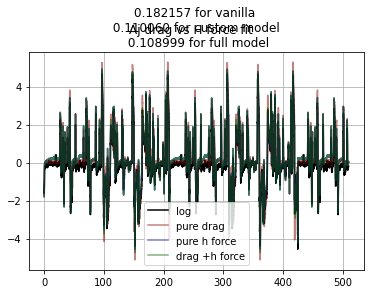

In [22]:
# %%%   ####### Comparison

f=plt.figure()
f.suptitle("Aj drag vs H force fit")
ax=f.add_subplot(1,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],compute_aj_od(dj_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],compute_aj_H_only(ch1_aj_only_,ch2_aj_only_),color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],compute_aj_H_wdrag(ch1_aj_only_,ch2_aj_only_,dj_wd_),color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aj_od['fun'],sol_aj_oh['fun'],sol_aj_hwd["fun"])
ax.set_title(s)
print(s)
# %% aij

In [23]:


# %%% H nodrag

def compute_aij_H_wdrag(ch1,ch2,di=0,dj=0,df=prep_data):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]

    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=np.c_[-vai*H,-vaj*H]
    
    Fa=-rho0*AN*np.c_[di*np.abs(vai)*vai,dj*np.abs(vaj)*vaj]

    return H_vect/mass+np.c_[gammai,gammaj]+Fa/mass

def cost_aij_h_nodrag(X):
    ch1,ch2=X
    Y=compute_aij_H_wdrag(ch1,ch2,di=0,dj=0)
    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)

    c=ci+cj
    print("ch1 :%f , ch2 :%f , cost :%f"%(ch1,ch2,c))

    return c

X0_aij_nodrag=np.array([0,0])

sol_aij_nodrag=minimize(cost_aij_h_nodrag,X0_aij_nodrag,method="SLSQP")
ch1_aij_nodrag_,ch2_aij_nodrag_=sol_aij_nodrag['x']



ch1 :0.000000 , ch2 :0.000000 , cost :0.776504
ch1 :0.000000 , ch2 :0.000000 , cost :0.776503
ch1 :0.000000 , ch2 :0.000000 , cost :0.776504
ch1 :59.517986 , ch2 :-5.163922 , cost :5143984.870599
ch1 :5.951799 , ch2 :-0.516392 , cost :51119.402229
ch1 :0.595180 , ch2 :-0.051639 , cost :479.841239
ch1 :0.059518 , ch2 :-0.005164 , cost :2.354999
ch1 :0.020633 , ch2 :-0.001790 , cost :0.157852
ch1 :0.020633 , ch2 :-0.001790 , cost :0.157852
ch1 :0.020633 , ch2 :-0.001790 , cost :0.157852
ch1 :0.011162 , ch2 :-0.113384 , cost :0.148919
ch1 :0.011162 , ch2 :-0.113384 , cost :0.148919
ch1 :0.011162 , ch2 :-0.113384 , cost :0.148919
ch1 :0.004177 , ch2 :-0.195678 , cost :0.146956
ch1 :0.004177 , ch2 :-0.195678 , cost :0.146956
ch1 :0.004177 , ch2 :-0.195678 , cost :0.146956


In [24]:


# %%% H wd


def cost_aij_h_wdrag(X):
    ch1,ch2,di,dj=X

    Y=compute_aij_H_wdrag(ch1,ch2,di,dj)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)

    c=ci+cj

    print("ch1 :%f , ch2 :%f , di :%f , dj : %f , cost :%f"%(ch1,ch2,di,dj,c))

    return c

X0_aij_hwd=np.array([0,0,0,0])

sol_aij_hwd=minimize(cost_aij_h_wdrag,X0_aij_hwd,method="SLSQP")
ch1_aij_wd_,ch2_aij_wd_,di_aij_wd_,dj_aij_wd_=sol_aij_hwd['x']

ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :0.776504
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :0.776503
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :0.776504
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :0.776504
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :0.776504
ch1 :59.517986 , ch2 :-5.163922 , di :0.089455 , dj : 5.295739 , cost :5223728.392692
ch1 :5.951799 , ch2 :-0.516392 , di :0.008946 , dj : 0.529574 , cost :51914.312693
ch1 :0.595180 , ch2 :-0.051639 , di :0.000895 , dj : 0.052957 , cost :487.537868
ch1 :0.059518 , ch2 :-0.005164 , di :0.000089 , dj : 0.005296 , cost :2.406718
ch1 :0.020478 , ch2 :-0.001777 , di :0.000031 , dj : 0.001822 , cost :0.157678
ch1 :0.020478 , ch2 :-0.001777 , di :0.000031 , dj : 0.001822 , cost :0.157678
ch1 :0.020478 , ch2 :-0.001777 , di :0.000031 , dj : 0.001822 , cost :0.157678
ch1 :0.020478 , ch2 :-0.001777 , di :0.00003


Performances: 
RMS error on acc pred is : 
0.039882 for vanilla 
  0.036819 for custom model 
 0.035430 for full model

Performances: 
RMS error on acc pred is : 
0.182157 for vanilla 
 1.582858 for custom model 
 1.594598 for full model


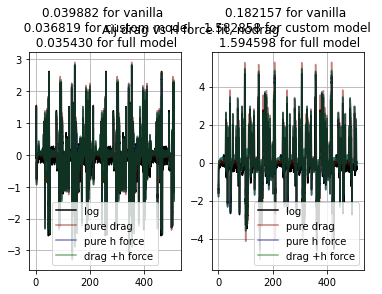

In [25]:



# %%% Comparison ai
aind,ajnd=compute_aij_H_wdrag(ch1_aij_nodrag_,ch2_aij_nodrag_).T
aid,ajd=compute_aij_H_wdrag(ch1_aij_wd_,ch2_aij_wd_,di_aij_wd_,dj_aij_wd_).T

f=plt.figure()
f.suptitle("Aij drag vs H force fit, nodrag")
ax=f.add_subplot(1,2,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],compute_ai_od(di_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],aind,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],aid,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_nd=np.mean((aind-prep_data['acc_body_grad[0]'])**2,axis=0)
c_i_d=np.mean((aid-prep_data['acc_body_grad[0]'])**2,axis=0)                            
s="%f for vanilla \n  %f for custom model \n %f for full model"%(sol_ai_od['fun'],c_i_nd,c_i_d)
ax.set_title(s)
print(s)

# %%% Comparison aj

ax=f.add_subplot(1,2,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],compute_aj_od(dj_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],ajnd,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],ajd,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_j_nd=np.mean((ajnd-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_d=np.mean((ajd-prep_data['acc_body_grad[0]'])**2,axis=0)  
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aj_od['fun'],c_j_nd,c_j_d)
ax.set_title(s)
print(s)



In [26]:


# %% aij (di_eq_dj)
 
# %%% H nodrag

def compute_aij_H_wdrag(ch1,ch2,di=0,dj=0,df=prep_data):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]

    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=np.c_[-vai*H,-vaj*H]
    
    Fa=-rho0*AN*np.c_[di*np.abs(vai)*vai,dj*np.abs(vaj)*vaj]

    return H_vect/mass+np.c_[gammai,gammaj]+Fa/mass


# %%% H wd


def cost_aij_h_wdrag_di_eq_dj_(X):
    ch1,ch2,di=X

    Y=compute_aij_H_wdrag(ch1,ch2,di,di)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)

    c=ci+cj

    print("ch1 :%f , ch2 :%f , dij :%f  , cost :%f"%(ch1,ch2,di,c))

    return c

X0_aij_hwd_di_eq_dj_=np.array([0,0,0])

sol_aij_hwd_di_eq_dj_=minimize(cost_aij_h_wdrag_di_eq_dj_,X0_aij_hwd_di_eq_dj_,method="SLSQP")
ch1_aij_wd_di_eq_dj_,ch2_aij_wd_di_eq_dj_,dij_aij_wd_di_eq_dj_=sol_aij_hwd_di_eq_dj_['x']


ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :0.776504
ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :0.776503
ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :0.776504
ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :0.776504
ch1 :59.517986 , ch2 :-5.163922 , dij :5.385194  , cost :5226284.513365
ch1 :5.951799 , ch2 :-0.516392 , dij :0.538519  , cost :51939.788628
ch1 :0.595180 , ch2 :-0.051639 , dij :0.053852  , cost :487.784101
ch1 :0.059518 , ch2 :-0.005164 , dij :0.005385  , cost :2.408327
ch1 :0.020474 , ch2 :-0.001776 , dij :0.001852  , cost :0.157655
ch1 :0.020474 , ch2 :-0.001776 , dij :0.001852  , cost :0.157655
ch1 :0.020474 , ch2 :-0.001776 , dij :0.001852  , cost :0.157655
ch1 :0.020474 , ch2 :-0.001776 , dij :0.001852  , cost :0.157655
ch1 :0.002164 , ch2 :-0.112119 , dij :0.102614  , cost :0.167543
ch1 :0.014100 , ch2 :-0.040189 , dij :0.036929  , cost :0.153710
ch1 :0.014100 , ch2 :-0.040189 , dij :0.036929  , cost :0.153710
ch1 :0.014100 , 


Performances: 
RMS error on acc pred is : 
0.146612 for vanilla 
 0.037459 for custom model 
 0.037243 for full model

Performances: 
RMS error on acc pred is : 
0.146612 for vanilla 
 1.585185 for custom model 
 1.591162 for full model


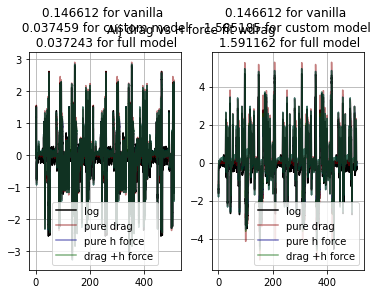

In [27]:


# %%% Comparison ai
aind,ajnd=compute_aij_H_wdrag(ch1_aij_wd_di_eq_dj_,ch2_aij_wd_di_eq_dj_).T
aid,ajd=compute_aij_H_wdrag(ch1_aij_wd_di_eq_dj_,ch2_aij_wd_di_eq_dj_,dij_aij_wd_di_eq_dj_,dij_aij_wd_di_eq_dj_).T

f=plt.figure()
f.suptitle("Aij drag vs H force fit wdrag")
ax=f.add_subplot(1,2,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],compute_ai_od(di_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],aind,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],aid,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_nd=np.mean((aind-prep_data['acc_body_grad[0]'])**2,axis=0)
c_i_d=np.mean((aid-prep_data['acc_body_grad[0]'])**2,axis=0)                            
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aij_hwd_di_eq_dj_['fun'],c_i_nd,c_i_d)
ax.set_title(s)
print(s)

# %%% Comparison aj

ax=f.add_subplot(1,2,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],compute_aj_od(dj_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],ajnd,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],ajd,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_j_nd=np.mean((ajnd-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_d=np.mean((ajd-prep_data['acc_body_grad[0]'])**2,axis=0)  
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aij_hwd_di_eq_dj_['fun'],c_j_nd,c_j_d)
ax.set_title(s)
print(s)

In [28]:


# %% Global 

def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H


def compute_single_motor_thrust_MT(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=c1*omega**2
    return T

def compute_acc_k(c1,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma
    
    return acc_k


def compute_acc_global(ct1,ct2,ch1,ch2,di=0,dj=0,dk=0,df=prep_data):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]
    gammak=df["gamma[2]"]
    
    T=sum([compute_single_motor_thrust_MT(ct1,vak,df['omega_c[%i]'%(i+1)],ct2) for i in range(6)])
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    
    H_vect=np.c_[-vai*H,-vaj*H,np.zeros(H.shape)]
    T_vect=np.c_[np.zeros(T.shape),np.zeros(T.shape),T]
    absva=np.sqrt(vai**2+vaj**2+vak**2)
    Fa=-rho0*AN*np.c_[di*absva*vai,dj*absva*vaj,dk*absva*vak]

    return -T_vect/mass+H_vect/mass+np.c_[gammai,gammaj,gammak]+Fa/mass


def cost_global_(X):
    ct1,ct2,ch1,ch2,di,dj,dk=X

    Y=compute_acc_global(ct1,ct2,ch1,ch2,di,dj,dk)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2/max(abs(prep_data['acc_body_grad[0]']))**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2/max(abs(prep_data['acc_body_grad[1]']))**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2/max(abs(prep_data['acc_body_grad[2]']))**2,axis=0)
    
    c=ci+cj+ck

    print("ct1 :%f, ct2 :%f , ch1 :%f , ch2 :%f , di :%f , dj : %f , dk : %f , cost :%f"%(ct1,ct2,ch1,ch2,di,dj,dk,c))

    return c

X0_global_=np.zeros(7)

sol_global_=minimize(cost_global_,X0_global_,method="SLSQP")
ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global=sol_global_['x']


ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768741
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746



Performances: 
RMS error on acc pred is : 
0.036524 for i 
 0.109964 for j 
 0.575474 for k


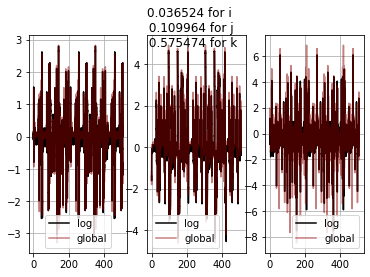

In [29]:




# %%% Comparison a i j k
Y=compute_acc_global(ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global)

f=plt.figure()
ax=f.add_subplot(1,3,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,0],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(1,3,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,1],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(1,3,3)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,2],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)  
c_k_=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2,axis=0)  


s="%f for i \n %f for j \n %f for k"%(c_i_,c_j_,c_k_)
f.suptitle(s)
print(s)



In [30]:


# %% Global 

def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H


def compute_single_motor_thrust_MT(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=c1*omega**2
    return T

def compute_acc_k(c1,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma
    
    return acc_k


def compute_acc_global(ct1,ct2,ch1,ch2,di=0,dj=0,dk=0,df=prep_data,vwi=0,vwj=0):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]
    gammak=df["gamma[2]"]
    
    T=sum([compute_single_motor_thrust_MT(ct1,vak,df['omega_c[%i]'%(i+1)],ct2) for i in range(6)])
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    
    H_vect=np.c_[-vai*H,-vaj*H,np.zeros(H.shape)]
    T_vect=np.c_[np.zeros(T.shape),np.zeros(T.shape),T]
    absva=np.sqrt(vai**2+vaj**2+vak**2)
    Fa=-rho0*AN*np.c_[di*absva*vai,dj*absva*vaj,dk*absva*vak]

    return -T_vect/mass+H_vect+np.c_[gammai,gammaj,gammak]+Fa


def cost_global_dij_(X):
    ct1,ct2,ch1,ch2,dij,dk=X

    Y=compute_acc_global(ct1,ct2,ch1,ch2,dij,dij,dk)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2/max(abs(prep_data['acc_body_grad[0]']))**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2/max(abs(prep_data['acc_body_grad[1]']))**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2/max(abs(prep_data['acc_body_grad[2]']))**2,axis=0)
    
    c=ci+cj+ck

    print("ct1 :%f, ct2 :%f , ch1 :%f , ch2 :%f , di :%f , dj : %f , dk : %f , cost :%f"%(ct1,ct2,ch1,ch2,dij,dij,dk,c))

    return c

X0_global_dij_=np.zeros(6)

sol_global_dij_=minimize(cost_global_dij_,X0_global_dij_,method="SLSQP")
ct1_global,ct2_global,ch1_global,ch2_global,di_global,dk_global=sol_global_dij_['x']
dj_global=di_global


ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768741
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.768746
ct1 :319.671236, ct2 :-2.065279 , ch1 :5.662323 , ch2 :-0.487592 , di :0.545501 , dj : 0.545501 , dk : -0.204732 , cost :1798


Performances: 
RMS error on acc pred is : 
IJ EQUAL 
 0.036751 for i 
 0.110136 for j 
 0.579256 for k


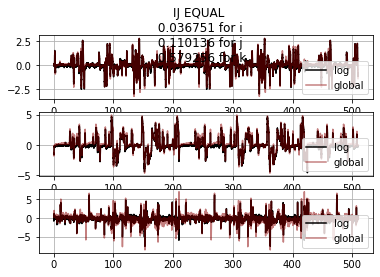

In [31]:

# %%% Comparison a i j k ij equal
Y=compute_acc_global(ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global)

f=plt.figure()
ax=f.add_subplot(3,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,0],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,1],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,3)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,2],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)  
c_k_=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2,axis=0)  


s="IJ EQUAL \n %f for i \n %f for j \n %f for k"%(c_i_,c_j_,c_k_)
f.suptitle(s)
print(s)




In [32]:


# %% WITH WIND 



def compute_acc_global_wind(ct1,ct2,ch1,ch2,di=0,dj=0,dk=0,df=prep_data,vwi=0,vwj=0):

    q0,q1,q2,q3=(prep_data['q[0]'],prep_data['q[1]'],
                 prep_data['q[2]'],prep_data['q[3]'])
    
    "precomputing transposition"
#     R_transpose=np.array([tf3d.quaternions.quat2mat([i,j,k,l]).T for i,j,k,l in zip(q0,q1,q2,q3)])
    
#     vw_earth=np.array([vwi,vwj,0])
    vw_body=vwi*np.array([i for i in df['vwx_body_dir'].values])+vwj*np.array([i for i in df['vwy_body_dir'].values])
    
    
    vai=df["speed_body[0]"]-vw_body[:,0]
    vaj=df["speed_body[1]"]-vw_body[:,1]
    vak=df["speed_body[2]"]-vw_body[:,2]
    
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]
    gammak=df["gamma[2]"]
    
    T=sum([compute_single_motor_thrust_MT(ct1,vak,df['omega_c[%i]'%(i+1)],ct2) for i in range(6)])
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    
    H_vect=np.c_[-vai*H,-vaj*H,np.zeros(H.shape)]
    T_vect=np.c_[np.zeros(T.shape),np.zeros(T.shape),T]
    absva=np.sqrt(vai**2+vaj**2+vak**2)
    Fa=-rho0*AN*np.c_[di*absva*vai,dj*absva*vaj,dk*absva*vak]

    return -T_vect/mass+H_vect/mass+np.c_[gammai,gammaj,gammak]+Fa/mass


def cost_global_dij_wind_(X):
    ct1,ct2,ch1,ch2,dij,dk,vwi,vwj=X

    Y=compute_acc_global_wind(ct1,ct2,ch1,ch2,dij,dij,dk,vwi=vwi,vwj=vwj)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2/max(abs(prep_data['acc_body_grad[0]']))**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2/max(abs(prep_data['acc_body_grad[1]']))**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2/max(abs(prep_data['acc_body_grad[2]']))**2,axis=0)
    
    c=ci+cj+ck

    print("ct1 :%f, ct2 :%f , ch1 :%f , ch2 :%f , di :%f , dj : %f , dk : %f , vwi : %f ,vwj : %f cost :%f"%(ct1,ct2,ch1,ch2,dij,dij,dk,vwi,vwj,c))

    return c


X0_global_dij_wind_=np.zeros(8)

sol_global_dij_wind_=minimize(cost_global_dij_wind_,X0_global_dij_wind_,method="SLSQP")
ct1_global,ct2_global,ch1_global,ch2_global,di_global,dk_global,vwi_global_,vwj_global_=sol_global_dij_wind_['x']
dj_global=di_global


ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.768741
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.768746
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , d


Performances: 
RMS error on acc pred is : 
WIND 
 0.125564 for i 
 0.168176 for j 
 0.538725 for k


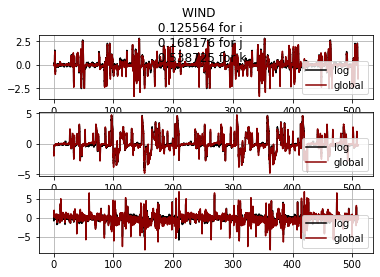

In [33]:
# % Comparison

Y=compute_acc_global_wind(ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global,vwi=vwi_global_,vwj=vwj_global_)



f=plt.figure()
ax=f.add_subplot(3,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,0],color="darkred",label="global")
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,1],color="darkred",label="global")
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,3)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,2],color="darkred",label="global")
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
# c_i_=np.sqrt(np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0))
# c_j_=np.sqrt(np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)  )
# c_k_=np.sqrt(np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2,axis=0)  )

c_i_=np.mean(np.abs(Y[:,0]-prep_data['acc_body_grad[0]']),axis=0)
c_j_=np.mean(np.abs(Y[:,1]-prep_data['acc_body_grad[1]']),axis=0)  
c_k_=np.mean(np.abs(Y[:,2]-prep_data['acc_body_grad[2]']),axis=0)  
s="WIND \n %f for i \n %f for j \n %f for k"%(c_i_,c_j_,c_k_)
f.suptitle(s)
print(s)



In [34]:





# %% Synthesis


bilan=pd.DataFrame(data=None,
                    columns=['ct1','ct2',
                            'ch1','ch2',
                            'di','dj','dk','vwi','vwj',
                            'cost'],
                    index=['vanilla','custom',
                          'vanilla_dk','custom_with_dk',
                          'ai_nodrag','ai_drag','ai_h','ai_drag_and_h',
                          'aj_nodrag','aj_drag','aj_h','aj_drag_and_h',
                          'aij_h','aij_h_and_drag',
                          'aij_h_drag_equal_coeffs',
                          "global","global_equal_coeffs","global_wind"])




bilan.loc["vanilla"]['ct1','cost']=np.r_[sol_vanilla['x'],np.sqrt(sol_vanilla['fun'])]
bilan.loc["custom"]['ct1','ct2','cost']=np.r_[sol_custom['x'],np.sqrt(sol_custom['fun'])]

bilan.loc["vanilla_dk"]['ct1','dk','cost']=np.r_[sol_vanilla_drag['x'],np.sqrt(sol_vanilla_drag['fun'])]
bilan.loc["custom_with_dk"]['ct1','ct2','dk','cost']=np.r_[sol_custom_drag['x'],np.sqrt(sol_custom_drag['fun'])]


bilan.loc['ai_nodrag']['cost']=np.sqrt(sol_ai_nod['fun'])
bilan.loc['ai_drag']['di','cost']=np.r_[sol_ai_od['x'],np.sqrt(sol_ai_od['fun'])]
bilan.loc['ai_h']['ch1','ch2','cost']=np.r_[sol_ai_oh['x'],np.sqrt(sol_ai_oh['fun'])]
bilan.loc['ai_drag_and_h']['ch1','ch2','di','cost']=np.r_[sol_ai_hwd['x'],np.sqrt(sol_ai_hwd['fun'])]

bilan.loc['aj_nodrag']['cost']=np.sqrt(sol_aj_nod['fun'])
bilan.loc['aj_drag']['dj','cost']=np.r_[sol_aj_od['x'],np.sqrt(sol_aj_od['fun'])]
bilan.loc['aj_h']['ch1','ch2','cost']=np.r_[sol_aj_oh['x'],np.sqrt(sol_aj_oh['fun'])]
bilan.loc['aj_drag_and_h']['ch1','ch2','dj','cost']=np.r_[sol_aj_hwd['x'],np.sqrt(sol_aj_hwd['fun'])]


bilan.loc['aij_h']['ch1','ch2','cost']=np.r_[sol_aij_nodrag['x'],np.sqrt(sol_aij_nodrag['fun'])]
bilan.loc['aij_h_and_drag']['ch1','ch2','di','dj','cost']=np.r_[sol_aij_hwd['x'],np.sqrt(sol_aij_hwd['fun'])]

bilan.loc['aij_h_drag_equal_coeffs']['ch1','ch2','di','cost']=np.r_[sol_aij_hwd_di_eq_dj_['x'],np.sqrt(sol_aij_hwd_di_eq_dj_['fun'])]
bilan.loc['aij_h_drag_equal_coeffs']['dj']=bilan.loc['aij_h_drag_equal_coeffs']['di']

bilan.loc['global']['ct1','ct2',
                    'ch1','ch2',
                    'di','dj','dk',
                    'cost']=np.r_[sol_global_['x'],np.sqrt(sol_global_['fun'])]

bilan.loc['global_equal_coeffs']['ct1','ct2',
                    'ch1','ch2',
                    'di','dk',
                    'cost']=np.r_[sol_global_dij_['x'],np.sqrt(sol_global_dij_['fun'])]

bilan.loc['global_equal_coeffs']["dj"]=bilan.loc['global_equal_coeffs']["di"]

bilan.loc['global_wind']['ct1','ct2',
                    'ch1','ch2',
                    'di','dk','vwi','vwj',
                    'cost']=np.r_[sol_global_dij_wind_['x'],np.sqrt(sol_global_dij_wind_['fun'])]
bilan.loc['global_wind']["dj"]=bilan.loc['global_wind']["di"]




print(bilan)


bilan.to_csv('./tableaux/bilan.csv')

                              ct1       ct2       ch1       ch2        di  \
vanilla                  0.010693       NaN       NaN       NaN       NaN   
custom                   0.019165  0.111517       NaN       NaN       NaN   
vanilla_dk               0.010919       NaN       NaN       NaN       NaN   
custom_with_dk           0.013786  0.038651       NaN       NaN       NaN   
ai_nodrag                     NaN       NaN       NaN       NaN       NaN   
ai_drag                       NaN       NaN       NaN       NaN   0.99731   
ai_h                          NaN       NaN  0.011199 -0.142606       NaN   
ai_drag_and_h                 NaN       NaN   0.00656 -0.128179  0.292452   
aj_nodrag                     NaN       NaN       NaN       NaN       NaN   
aj_drag                       NaN       NaN       NaN       NaN       NaN   
aj_h                          NaN       NaN  0.003234 -0.204344       NaN   
aj_drag_and_h                 NaN       NaN  0.001762 -0.196538       NaN   

In [35]:
# %% ID WIND ONLY



def cost_global_dij_wind_only(X):
    
    ct1,ct2,dk = bilan.loc["custom_with_dk"][['ct1','ct2','dk']].values
    ch1,ch2,di = bilan.loc['aij_h_drag_equal_coeffs'][['ch1','ch2','di']].values
    dij = di 
    
    vwi,vwj=X

    Y=compute_acc_global_wind(ct1,ct2,ch1,ch2,dij,dij,dk,vwi=vwi,vwj=vwj)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2/max(abs(prep_data['acc_body_grad[0]']))**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2/max(abs(prep_data['acc_body_grad[1]']))**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2/max(abs(prep_data['acc_body_grad[2]']))**2,axis=0)
    
    c=ci+cj+ck

    print(" vwi : %f ,vwj : %f cost :%f"%(vwi,vwj,c))

    return c


X0_global_dij_wind_only=np.zeros(2)

sol_global_dij_wind_only=minimize(cost_global_dij_wind_only,X0_global_dij_wind_only,method="SLSQP")
vwi_only_,vwj_only_= sol_global_dij_wind_only['x']


 vwi : 0.000000 ,vwj : 0.000000 cost :0.022727
 vwi : 0.000000 ,vwj : 0.000000 cost :0.022727
 vwi : 0.000000 ,vwj : 0.000000 cost :0.022727
 vwi : -0.005558 ,vwj : 0.001059 cost :0.022695
 vwi : -0.005558 ,vwj : 0.001059 cost :0.022695
 vwi : -0.005558 ,vwj : 0.001059 cost :0.022695
 vwi : -0.033130 ,vwj : 0.006261 cost :0.022541
 vwi : -0.033130 ,vwj : 0.006261 cost :0.022541
 vwi : -0.033130 ,vwj : 0.006261 cost :0.022541
 vwi : -0.165316 ,vwj : 0.030931 cost :0.021893
 vwi : -0.165316 ,vwj : 0.030931 cost :0.021893
 vwi : -0.165316 ,vwj : 0.030931 cost :0.021893
 vwi : -0.668824 ,vwj : 0.123640 cost :0.020810
 vwi : -0.668824 ,vwj : 0.123640 cost :0.020810
 vwi : -0.668824 ,vwj : 0.123640 cost :0.020810
 vwi : -0.664598 ,vwj : 0.121625 cost :0.020808
 vwi : -0.664598 ,vwj : 0.121625 cost :0.020808
 vwi : -0.664598 ,vwj : 0.121625 cost :0.020808
 vwi : -0.657362 ,vwj : 0.111278 cost :0.020798
 vwi : -0.657362 ,vwj : 0.111278 cost :0.020798
 vwi : -0.657362 ,vwj : 0.111278 cost :0.02

In [36]:

# %%   ####### Identify kt 

def compute_single_motor_thrust_MT(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T


def compute_single_motor_thrust_BET(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=rho0*Area*r0*omega*(c1*r0*omega-c2*(eta-vak))
    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T

def compute_omegas(df,kt):
    # omegas is shape n timesteps x p actuators 
    omegas=np.array([prep_data['omega_c[%i]'%(i+1)] for i in range(6)]).T
    
    b, a = scipy.signal.butter(1, 1./(2*np.pi)*kt,analog= False,fs=1./2.0/df['dt'].mean())
    zi = scipy.signal.lfilter_zi(b, a)
    new_omegas, _ =scipy.signal.lfilter(b, a, omegas,axis=0,zi=zi*omegas[0].reshape((1,-1)))
    return new_omegas



def compute_acc_k_wdrag_kt(c1,dk,kt,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    omegas=compute_omegas(df,kt)
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,omegas[:,i],c2,vanilla_test=vanilla) for i in range(6)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,omegas[:,i],c2,vanilla_test=vanilla) for i in range(6)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma-rho0*AN*dk*np.abs(vak)*vak/mass
    
    return acc_k


def cost_vanilla_kt(X):
    c1,dk,kt=X
    Y=compute_acc_k_wdrag_kt(c1,dk,kt,vanilla=True)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f , dk :%f , kt :%f VANILLA ,cost :%f"%(c1,dk,kt,c))
    return c

X0_vanilla_kt=np.array([0,0,1.0])

sol_vanilla_kt=minimize(cost_vanilla_kt,X0_vanilla_kt,method="SLSQP")
c1vanillakt,dkvanillakt,ktvanillakt=sol_vanilla_kt['x']
print("\n \n")

print("Final RMS ", np.sqrt(sol_vanilla_kt['fun']))

c1 :0.000000 , dk :0.000000 , kt :1.000000 VANILLA ,cost :97.932528
c1 :0.000000 , dk :0.000000 , kt :1.000000 VANILLA ,cost :97.932261
c1 :0.000000 , dk :0.000000 , kt :1.000000 VANILLA ,cost :97.932528
c1 :0.000000 , dk :0.000000 , kt :1.000000 VANILLA ,cost :97.932528
c1 :17876.224611 , dk :-3.197740 , kt :1.000000 VANILLA ,cost :264101842751938.906250
c1 :1787.622461 , dk :-0.319774 , kt :1.000000 VANILLA ,cost :2640989667248.940430
c1 :178.762246 , dk :-0.031977 , kt :1.000000 VANILLA ,cost :26407020732.704601
c1 :17.876225 , dk :-0.003198 , kt :1.000000 VANILLA ,cost :263782700.606428
c1 :1.787622 , dk :-0.000320 , kt :1.000000 VANILLA ,cost :2609163.591885
c1 :0.178762 , dk :-0.000032 , kt :1.000000 VANILLA ,cost :23312.552383
c1 :0.017876 , dk :-0.000003 , kt :1.000000 VANILLA ,cost :42.475052
c1 :0.017876 , dk :-0.000003 , kt :1.000000 VANILLA ,cost :42.475226
c1 :0.017876 , dk :-0.000003 , kt :1.000000 VANILLA ,cost :42.475052
c1 :0.017876 , dk :-0.000003 , kt :1.000000 VANIL

In [37]:
# %% Global Optimization ACC

def compute_single_motor_thrust_(omega,vai,vaj,vak,c1,c2=0,c3=0,vanilla_test=False):
    
    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
        return T
    else:
        eta=vak/2-r0*omega*c2/4
        eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2
                            +2*c1*r0**2*omega**2+2*c3*(vai**2+vaj**2))

        T=rho0*Area*r0*omega*(c1*r0*omega-c2*(eta-vak))+rho0*Area*c3*(vai**2+vaj**2)
        return T

def compute_omegas(df,kt):
    # omegas is shape n timesteps x p actuators 
    omegas=np.array([df['omega_c[%i]'%(i+1)] for i in range(6)]).T
    
    b, a = scipy.signal.butter(1, 1./(2*np.pi)*kt,analog= False,fs=1./2.0/df['dt'].mean())
    zi = scipy.signal.lfilter_zi(b, a)
    new_omegas, _ =scipy.signal.lfilter(b, a, omegas,axis=0,zi=zi*omegas[0].reshape((1,-1)))
    return new_omegas


def compute_H(omega,vai,vaj,vak,ch1,ch2,c1=0,c2=0,c3=0,vanilla_test=False):
    if vanilla_test:
        return np.zeros(omega.shape)
    else:
        eta=vak/2-r0*omega*c2/4
        eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2
                            +2*c1*r0**2*omega**2+2*c3*(vai**2+vaj**2))
        H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
        return H

def compute_acc_identification_globale(ct1,
                                       ct2,
                                       ch1,
                                       ch2,
                                       di=0,
                                       dj=0,
                                       dk=0,
                                       df=prep_data,
                                       kt=0.0,
                                       ct3=0,
                                       vwi=0,
                                       vwj=0,
                                      vanilla=False,
                                       dyn_motors=False):
    
    vw_body=vwi*np.array([i for i in df['vwx_body_dir'].values])+vwj*np.array([i for i in df['vwy_body_dir'].values])
    
    
    vai=df["speed_body[0]"]-vw_body[:,0]
    vaj=df["speed_body[1]"]-vw_body[:,1]
    vak=df["speed_body[2]"]-vw_body[:,2]
    
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]
    gammak=df["gamma[2]"]
    
    omegas = compute_omegas(df,kt).reshape((len(df),6)) if dyn_motors else np.array([df['omega_c[%i]'%(i+1)] for i in range(6)]).T
    
    
    T=sum([compute_single_motor_thrust_(omegas[:,i],
         vai,vaj,vak,
                    ct1,ct2,ct3,vanilla_test=vanilla) for i in range(6)])
    
    H=sum([compute_H(omegas[:,i],
          vai,vaj,vak,ch1,ch2,
                     ct1,ct2,ct3,vanilla_test=vanilla) for i in range(6)])
    
    H_vect=np.c_[-vai*H,-vaj*H,np.zeros(H.shape)]
    T_vect=np.c_[np.zeros(T.shape),np.zeros(T.shape),T]
    
    absva=np.sqrt(vai**2+vaj**2+vak**2)
    Fa=-rho0*AN*np.c_[di*absva*vai,dj*absva*vaj,dk*absva*vak]

    return -T_vect/mass+H_vect/mass+np.c_[gammai,gammaj,gammak]+Fa/mass


def cost_global_(X,option_booleans,rms_score=False):
    
    ct1,ct2,ch1,ch2,di,dj,dk,ct3,kt,vwi,vwj = X

    motor_dyn , vanilla , with_c3 , dij , with_wind = option_booleans

    ct3 = ct3 if with_c3 else 0
    vwi,vwj=(vwi,vwj) if with_wind else (0,0) 
    dj = di if dij else dj
          
          
    Y=compute_acc_identification_globale(ct1,
                                       ct2,
                                       ch1,
                                       ch2,                                       
                                        di=di,
                                       dj=dj,
                                       dk=dk,
                                       kt=kt,
                                       ct3=ct3,
                                       vwi=vwi,
                                       vwj=vwj,
                                      vanilla=vanilla,
                                       dyn_motors=motor_dyn)
          
    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2,axis=0)
    if rms_score==False:
        ci/=max(abs(prep_data['acc_body_grad[0]']))**2
        cj/=max(abs(prep_data['acc_body_grad[1]']))**2
        ck/=max(abs(prep_data['acc_body_grad[2]']))**2
        
        
        c=ci+cj+ck
#         print("ct1:%f ct2:%f ch1:%f ch2:%f di:%f dj:%f dk:%f ct3:%f kt:%f vwi:%f vwj:%f cost:%f"%(ct1,ct2,ch1,ch2,di,dj,dk,ct3,kt,vwi,vwj,c))

        return c

    else:
        score_rms_total=np.mean(np.linalg.norm(Y-np.c_[prep_data['acc_body_grad[0]'],prep_data['acc_body_grad[1]'],prep_data['acc_body_grad[2]']],axis=1))
        return np.sqrt([score_rms_total,ci,cj,ck])

    
    
    

In [38]:

params = []

for motor_dyn in (True,False):
    for vanilla in (True,False):
        for with_c3 in (True,False):
            for dij in (True,False):
                for with_wind in (True,False):
                    if not( vanilla and with_c3):
                        params.append([motor_dyn , vanilla , with_c3 , dij , with_wind])  
                    
print("N combinaisons: ",len(params))

keys_dict_=['ct1,ct2,ch1,ch2,di,dj,dk,ct3,kt,vwi,vwj'.split(',')]


X0_id_globale=np.array([bilan.loc["custom_with_dk"]['ct1'],
                        bilan.loc["custom_with_dk"]['ct2'],
                        bilan.loc["aij_h_and_drag"]['ch1'],
                        bilan.loc["aij_h_and_drag"]['ch2'],
                        bilan.loc["aij_h_and_drag"]['di'],
                        bilan.loc["aij_h_and_drag"]['dj'],
                        bilan.loc["custom_with_dk"]['dk'],
                        0, #c3
                        ktvanillakt, #kt
                        0, #vwi
                        0]) #vwj



headers_df = ['motor_dyn,vanilla,with_c3,dij,with_wind'.replace(' ','').split(',')]
headers_df = headers_df + ['ct1,ct2,ch1,ch2,di,dj,dk,ct3,kt,vwi,vwj'.replace(' ','').split(',')]
headers_df = headers_df + ['score_opti,score_rms,score_x,score_y,score_z,duration'.replace(' ','').split(',')]
headers_df = [item for sublist in headers_df for item in sublist]


N combinaisons:  24


In [40]:
# %% global acc opti: multi thread run
from multiprocessing import Pool
import time

def run_in_process(params_el):
    
    acc_data_list=[]

    t0=time.time()
    
    sol_= minimize(cost_global_,X0_id_globale,args=(params_el))
    score_rms,score_x,score_y,score_z = cost_global_(sol_['x'],params_el,rms_score=True)
    
    optim_duration = time.time()-t0
    
    acc_data_list.append(np.r_[params_el,sol_['x'],sol_['fun'],score_rms,score_x,score_y,score_z,optim_duration])
    
    df_res =  pd.DataFrame(data=acc_data_list,columns=headers_df)   
    sname=''
    for i in params_el:
        sname=sname+'T' if i else sname+'F' 
    df_res.to_csv('./nosympy_temp/acc_'+sname+".csv")
    print(params_el,"Done...")
    return True
    
if __name__ == '__main__':

    pool = Pool(processes=10)
    pool.map(run_in_process, params)

    

[True, True, False, True, False] Done...
[True, True, False, False, False] Done...
[True, True, False, True, True] Done...
[True, True, False, False, True] Done...
[False, True, False, True, False] Done...
[True, False, False, True, False] Done...
[False, True, False, True, True] Done...
[False, True, False, False, False] Done...
[True, False, False, True, True] Done...
[True, False, True, True, True] Done...
[True, False, True, False, True] Done...
[True, False, True, True, False] Done...
[True, False, False, False, True] Done...
[True, False, True, False, False] Done...
[False, True, False, False, True] Done...
[False, False, True, True, True] Done...
[False, False, True, True, False] Done...
[False, False, False, True, True] Done...
[False, False, True, False, True] Done...
[True, False, False, False, False] Done...
[False, False, False, True, False] Done...
[False, False, True, False, False] Done...
[False, False, False, False, True] Done...
[False, False, False, False, False] Done

Process ForkPoolWorker-10:
Process ForkPoolWorker-7:
Process ForkPoolWorker-1:
Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Process ForkPoolWorker-4:
Process ForkPoolWorker-9:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/l3x/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/l3x/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/l3x/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/l3x/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/l3x/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
   

In [56]:

import os
df_res =  pd.concat([pd.read_csv("./nosympy_temp/"+i, index_col=[0]) for i in os.listdir('./nosympy_temp') if "acc" in i])   
df_res

,motor_dyn,vanilla,with_c3,dij,with_wind,ct1,ct2,ch1,ch2,di,...,ct3,kt,vwi,vwj,score_opti,score_rms,score_x,score_y,score_z,duration
0,0.0,1.0,0.0,0.0,0.0,0.010911,0.038651,0.001945,-0.193721,0.257472,...,0.000000,6.923363,0.000000,0.000000,0.023881,0.857054,0.232479,0.412392,0.763011,242.066644
0,0.0,1.0,0.0,0.0,1.0,0.010918,0.038651,0.001945,-0.193721,0.232113,...,0.000000,6.923363,-1.287071,0.128436,0.021398,0.836068,0.207920,0.374195,0.765168,1412.539474
0,0.0,0.0,0.0,1.0,0.0,0.013184,0.030592,0.005508,-0.177413,0.004321,...,0.000000,6.923363,0.000000,0.000000,0.019133,0.828170,0.191703,0.331873,0.757731,1162.007470
0,1.0,1.0,0.0,1.0,1.0,0.011013,0.038651,0.001945,-0.193721,0.177261,...,0.000000,6.468738,-1.466325,0.493859,0.018515,0.799333,0.212184,0.372685,0.643490,1037.539896
0,1.0,0.0,0.0,1.0,0.0,0.014473,0.046456,0.005269,-0.184676,0.000308,...,0.000000,6.184380,0.000000,0.000000,0.015988,0.789878,0.191309,0.330138,0.632309,1433.208541
0,1.0,0.0,1.0,1.0,0.0,0.013186,0.030994,0.005254,-0.190458,-0.011355,...,0.113518,6.583527,0.000000,0.000000,0.014429,0.775514,0.191133,0.329647,0.559228,2145.041176
0,1.0,1.0,0.0,1.0,0.0,0.011003,0.038651,0.001945,-0.193721,0.186732,...,0.000000,6.540212,0.000000,0.000000,0.021217,0.823356,0.237368,0.412844,0.645148,537.807276
0,0.0,0.0,0.0,0.0,0.0,0.013185,0.030598,0.005269,-0.177197,0.031652,...,0.000000,6.923363,0.000000,0.000000,0.019100,0.828018,0.191170,0.331528,0.757731,827.750505
0,0.0,0.0,1.0,0.0,1.0,0.012886,0.028317,0.006356,-0.159636,0.036691,...,0.103493,6.923363,-1.043246,-0.195141,0.014343,0.783611,0.170710,0.234371,0.701618,1128.347194
0,1.0,0.0,0.0,0.0,1.0,0.014597,0.047929,0.006459,-0.154874,0.043901,...,0.000000,6.187213,-1.058234,-0.204050,0.012648,0.747132,0.170830,0.232137,0.631404,1864.598353


In [55]:
df_res=np.round(df_res.sort_values(by=['score_rms'],ascending=[True]),4)

df_res.to_csv('./tableaux/global_acc.csv')

In [ ]:
# # %% global acc opti: single thread run

# acc_data_list=[]

# for i,params_el in enumerate(params):
    
#     print(i,"/",len(params))
#     t0=time.time()
    
#     sol_= minimize(cost_global_,X0_id_globale,args=(params_el))
#     score_rms,score_x,score_y,score_z = cost_global_(sol_['x'],params_el,rms_score=True)
    
#     optim_duration = time.time()-t0
    
#     acc_data_list.append(np.r_[params_el,sol_['x'],sol_['fun'],score_rms,score_x,score_y,score_z,optim_duration])
    
# df_res =  pd.DataFrame(data=acc_data_list,columns=headers_df)   
# df_res.sort_values(by=['dij','score_opti'],ascending=(False,True))

In [ ]:
# %% Speed identification

def model_forces(ct1,ct2,
               ch1,ch2,
               drag_coeffs=np.zeros(3),
                va_body_pred=np.zeros(3),
                 omegas=np.zeros(6),
               ct3=0,
              vanilla=False):
    
    vai,vaj,vak=va_body_pred

    T=sum(compute_single_motor_thrust_(omegas,
         vai,vaj,vak,
                    ct1,ct2,ct3,vanilla_test=vanilla))
    
    H=sum(compute_H(omegas,
          vai,vaj,vak,ch1,ch2,
                     ct1,ct2,ct3,vanilla_test=vanilla))
    
    T_vect=np.array([0,0,T])
    H_vect=np.array([-vai*H,-vaj*H,0])
    
    absva=np.linalg.norm(va_body_pred)
    Fa=-rho0*AN*absva*np.diag(drag_coeffs)@va_body_pred

    
    return -T_vect+H_vect+Fa


    


def predict_speed(ct1,
                   ct2,
                   ch1,
                   ch2,
                   di=0,
                   dj=0,
                   dk=0,
                   df=prep_data,
                   kt=0.0,
                   ct3=0,
                   vwi=0,
                   vwj=0,
                  vanilla=False,
                   dyn_motors=False):
    
    pred_speed_ned=np.zeros((len(df),3))
    pred_speed_ned[0]=np.array([df['speed[0]'].values[0],df['speed[1]'].values[0],df['speed[2]'].values[0]])
    
    omegas = compute_omegas(df,kt).reshape((len(df),6)) if dyn_motors else np.array([df['omega_c[%i]'%(i+1)] for i in range(6)]).T
    
    vw_body=vwi*np.array([i for i in df['vwx_body_dir'].values])+vwj*np.array([i for i in df['vwy_body_dir'].values])
    drag_coeffs=np.array([di,dj,dk])
                   
    
    for i in range(len(df)-1):
        R_temp=np.array(df['R'].values[i])
        v_body_pred= R_temp.T@(pred_speed_ned[i])
        
        forces=model_forces(ct1,ct2,ch1,ch2,
               drag_coeffs=drag_coeffs,
                va_body_pred=v_body_pred-vw_body[i],
                 omegas=omegas[i],
               ct3=ct3,
              vanilla=vanilla)
        

        acc_ned= R_temp@forces/mass + np.array([0,0,9.81])
        
        pred_speed_ned[i+1] = pred_speed_ned[i]+min(2e-2,df['dt'].values[i])*acc_ned
        
    return pred_speed_ned


def cost_global_speed_(X,option_booleans,df=prep_data,rms_score=False):
    
    ct1,ct2,ch1,ch2,di,dj,dk,ct3,kt,vwi,vwj = X

    motor_dyn , vanilla , with_c3 , dij , with_wind = option_booleans

    ct3 = ct3 if with_c3 else 0
    vwi,vwj=(vwi,vwj) if with_wind else (0,0) 
    dj = di if dij else dj
          
          
    Y=predict_speed(ct1,
                   ct2,
                   ch1,
                   ch2,
                   di=di,
                   dj=dj,
                   dk=dk,
                   df=df,
                   kt=kt,
                   ct3=ct3,
                   vwi=vwi,
                   vwj=vwj,
                  vanilla=vanilla,
                   dyn_motors=motor_dyn)
          
    ci=np.mean((Y[:,0]-df['speed[0]'])**2,axis=0)
    cj=np.mean((Y[:,1]-df['speed[1]'])**2,axis=0)
    ck=np.mean((Y[:,2]-df['speed[2]'])**2,axis=0)
    if rms_score==False:
        ci/=max(abs(df['speed[0]']))**2
        cj/=max(abs(df['speed[1]']))**2
        ck/=max(abs(df['speed[2]']))**2
        
        
        
        c=ci+cj+ck
#         print("ct1:%f ct2:%f ch1:%f ch2:%f di:%f dj:%f dk:%f ct3:%f kt:%f vwi:%f vwj:%f cost:%f"%(ct1,ct2,ch1,ch2,di,dj,dk,ct3,kt,vwi,vwj,c))

        return c

    else:
        score_rms_total=np.mean(np.linalg.norm(Y-np.c_[df['speed[0]'],df['speed[1]'],df['speed[2]']],axis=1))
        return np.sqrt([score_rms_total,ci,cj,ck])

    

In [ ]:

# params = []

# for motor_dyn in (True,False):
#     for vanilla in (True,False):
#         for with_c3 in (True,False):
#             for dij in (True,False):
#                 for with_wind in (True,False):
#                     if not( vanilla and with_c3):
#                         params.append([motor_dyn , vanilla , with_c3 , dij , with_wind])                    
               
# print("N param combinasions: ",len(params))
# keys_dict_=['ct1,ct2,ch1,ch2,di,dj,dk,ct3,kt,vwi,vwj'.split(',')]


# X0_id_globale=np.array([bilan.loc["custom_with_dk"]['ct1'],
#                         bilan.loc["custom_with_dk"]['ct2'],
#                         bilan.loc["aij_h_and_drag"]['ch1'],
#                         bilan.loc["aij_h_and_drag"]['ch2'],
#                         bilan.loc["aij_h_and_drag"]['di'],
#                         bilan.loc["aij_h_and_drag"]['dj'],
#                         bilan.loc["custom_with_dk"]['dk'],
#                         0, #c3
#                         ktvanillakt, #kt
#                         0, #vwi
#                         0]) #vwj

# headers_df = ['motor_dyn,vanilla,with_c3,dij,with_wind'.replace(' ','').split(',')]
# headers_df = headers_df + ['ct1,ct2,ch1,ch2,di,dj,dk,ct3,kt,vwi,vwj'.replace(' ','').split(',')]
# headers_df = headers_df + ['score_opti,score_rms,score_x,score_y,score_z,duration'.replace(' ','').split(',')]
# headers_df = [item for sublist in headers_df for item in sublist]


In [ ]:
# # %% global speed opti: parallel run
# from multiprocessing import Pool

# def run_in_process(params_el):
    
#     speed_data_list=[]

#     t0=time.time()
    
#     sol_= minimize(cost_global_speed_,X0_id_globale,args=(params_el,prep_data))
#     score_rms,score_x,score_y,score_z = cost_global_speed_(sol_['x'],params_el,rms_score=True)
    
#     optim_duration = time.time()-t0
    
#     speed_data_list.append(np.r_[params_el,sol_['x'],sol_['fun'],score_rms,score_x,score_y,score_z,optim_duration])
    
#     df_res =  pd.DataFrame(data=speed_data_list,columns=headers_df)   
#     df_res.to_csv('./nosympy_temp/speed_'+str(time.time())+str(round(10000*np.random.random()))+".csv")
#     print(params_el,"Done...")


# if __name__ == '__main__':

#     pool = Pool(processes=10)
#     pool.map(run_in_process, params)

    
# import os
# df_res =  pd.concat([pd.read_csv("/nosympy_temp/"+i) for i in os.listdir('./nosympy_temp') if "speed" in i])   
# df_res.sort_values(by=['dij','score_opti'],ascending=(False,True))

In [ ]:
# %% global speed opti: single thread run
# speed_data_list=[]

# for i,params_el in enumerate(params):
    
#     print(i,"/",len(params))
#     t0=time.time()
    
#     sol_= minimize(cost_global_speed_,X0_id_globale,args=(params_el,prep_data))
#     score_rms,score_x,score_y,score_z = cost_global_speed_(sol_['x'],params_el,rms_score=True)
    
#     optim_duration = time.time()-t0
    
#     speed_data_list.append(np.r_[params_el,sol_['x'],sol_['fun'],score_rms,score_x,score_y,score_z,optim_duration])
    
# df_res =  pd.DataFrame(data=data_list,columns=headers_df)   
# df_res.sort_values(by=['dij','score_opti'],ascending=(False,True))

In [ ]:
def genbatches(dataframe,nsecs):
        
    if nsecs=='all':
        return [dataframe]
    else:
        N_minibatches=round(dataframe["t"].max()/nsecs) # 22 for flight 1, ?? for flight 2
        return np.array_split(dataframe, N_minibatches)
    

In [ ]:
# %% global speed opti: parallel run with batches


headers_df = ['motor_dyn,vanilla,with_c3,dij,with_wind'.replace(' ','').split(',')]
headers_df = headers_df + ['ct1,ct2,ch1,ch2,di,dj,dk,ct3,kt,vwi,vwj'.replace(' ','').split(',')]
headers_df = headers_df + ['score_opti,score_rms,score_x,score_y,score_z,duration,nsecs,nbatch'.replace(' ','').split(',')]
headers_df = [item for sublist in headers_df for item in sublist]


params_batches = []

for motor_dyn in (True,False):
    for vanilla in (True,False):
        for with_c3 in (True,False):
            for dij in (True,False):
                for with_wind in (True,False):
                    for batch_size_in_secs in [0.5,2,10,30]:
                        if not( vanilla and with_c3):
                            params_batches.append([motor_dyn , vanilla , with_c3 , dij , with_wind ,batch_size_in_secs]) 
                        
print(len(params_batches)," param sets")              

#     ct1,ct2,ch1,ch2,di,dj,dk,ct3,kt,vwi,vwj = X
bnds=[(0,None),
      (None,None),
      (0,None),
      (None,None),
      (0,None),
      (0,None),
      (0,None),
      (None,None),
      (1,15),
      (-8,8),
      (-8,8)]

from multiprocessing import Pool

def run_in_process(params_el):
    
    batch_size_in_secs=params_el[-1]
    
    batches=genbatches(prep_data,batch_size_in_secs)
    
    for i,df in enumerate(batches):

        speed_data_list=[]

        t0=time.time()

#         print(i,"/", len(batches)," begin optim")
        
        sol_= minimize(cost_global_speed_,X0_id_globale,bounds=bnds,args=(params_el[:-1],df))
        
#         print(i,"/", len(batches)," computing scores ")

        score_rms,score_x,score_y,score_z = cost_global_speed_(sol_['x'],params_el[:-1],prep_data,rms_score=True)
#         print('here?')
            
        optim_duration = time.time()-t0

        speed_data_list.append(np.r_[params_el[:-1],sol_['x'],sol_['fun'],
                                     score_rms,score_x,score_y,score_z,optim_duration,
                                    batch_size_in_secs,i])
#         print(speed_data_list)
        df_res =  pd.DataFrame(data=speed_data_list,columns=headers_df)   
#         print(df_res)
        df_res.to_csv('./res_helice_parallel_30_oct_nosympy/speed_'+str(time.time())+str(round(10000*np.random.random()))+".csv")
#         print(i,"/", len(batches),"  ", params_el, "DONE") 


if __name__ == '__main__':

    pool = Pool(processes=5)
    pool.map(run_in_process, params_batches)
    

In [ ]:

    
import os
df_res =  pd.concat([pd.read_csv("/res_helice_parallel_30_oct_nosympy/"+i) for i in os.listdir('./res_helice_parallel_30_oct_nosympy') if "speed" in i])   
df_res.sort_values(by=['dij','score_opti'],ascending=(False,True))run_in_process